<h1>Analysis 2 - Study of correlation between external factors and BLH</h1>

This is based on Shaohua Liu workbook Analysis 2 (20/5/2021)

Added in WRF data

<h2>Section 1 - Preprocessing</h2>

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date
from datetime import timedelta

In [2]:
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [4]:
def convert_df_to_datetime_wrf(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H:%M:%S')+ timedelta(hours=10)
    
    #Set index to datetime
    df = df.set_index('datetime')
    
    #Keep the last index
    #As per Hiep response - 24/8/2021 - we keep last value

    df = df[~df.index.duplicated(keep = 'last')]

    df = df.reset_index()
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [5]:
'''
2. Import WRF data and parse accordingly
'''

data_path = "D:\MSDS\DS Project\Data"

wrf_data_path = "\\WRF"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)

wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

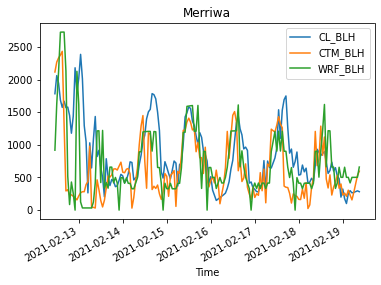

In [8]:
bl_plot('Merriwa', wrf_df_merriwa)


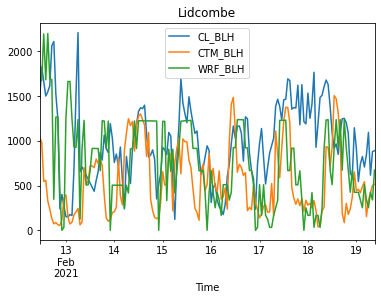

In [9]:
bl_plot('Lidcombe', wrf_df_lidcombe)


In [7]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [8]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [9]:
df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]
#params

In [10]:
#TK 28/7/2021: Added BL diff - can/should we use this as a feature..?
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-20',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [9]:
#df = bl_external('Merriwa', 329)
#df

In [11]:
data = {site: bl_external(site, id) for site, id in sites.items()}

In [16]:
df = data['Merriwa']

df

,Date,Hour,CL_BLH,CTM_BLH,WRF_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,Ozone,PM10,PM2.5,Rainfall,Sulphur Dioxide,Temperature,Wind Direction (10m),Wind Direction Sigma Theta,Wind Speed (10m),BL_diff
0,2021-02-12,11,1782.971698,2116.5154,918.04,-0.013024,47.927,0.042,-0.023461,0.069158,2.544080,23.290,1.629,0.0,0.012478,26.696,331.472,14.912,7.140,-333.543702
1,2021-02-12,12,2060.904255,2268.4509,1629.29,-0.003834,46.820,0.051,-0.015987,0.076345,2.843780,18.506,7.472,0.0,0.009091,27.329,341.235,15.817,5.896,-207.546645
2,2021-02-12,13,1942.894737,2332.6211,2124.96,-0.004704,45.996,0.058,-0.011745,0.066663,3.053180,22.723,6.195,0.0,0.016463,28.087,345.758,13.917,6.096,-389.726363
3,2021-02-12,14,1684.731183,2376.4629,2726.00,-0.003592,44.181,0.060,-0.026188,0.057879,3.265180,19.386,2.025,0.0,0.031706,28.844,333.913,13.932,6.070,-691.731717
4,2021-02-12,15,1573.967391,2432.8503,2727.78,-0.002880,43.716,0.065,-0.021037,0.052190,3.347480,19.332,-4.037,0.0,0.039776,29.141,339.577,17.870,5.807,-858.882909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021-02-19,5,264.802803,156.5146,501.85,-0.033830,91.658,0.102,-0.022306,0.170322,1.083695,12.816,1.575,0.0,0.102550,17.554,129.513,10.023,2.405,108.288203
162,2021-02-19,6,271.336676,271.2063,501.62,-0.035252,91.979,0.105,-0.011042,0.139426,1.114095,9.865,2.849,0.0,0.076057,17.778,130.756,9.991,2.853,0.130376
163,2021-02-19,7,283.446311,402.5884,502.13,-0.032138,92.351,0.099,0.039190,0.266695,1.040695,10.615,2.504,0.0,0.160537,18.322,109.467,27.944,3.619,-119.142089
164,2021-02-19,8,295.176486,530.2465,503.18,-0.027304,92.986,0.131,0.079679,0.325995,0.962895,12.016,1.007,1.6,0.100951,18.662,117.478,10.160,4.088,-235.070014


<h2>Section 2 - Correlation analysis</h2>

In [12]:
def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [13]:
corr('all', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.287952,0.441482
CTM_BLH,0.287952,1.000000,0.499293
WRF_BLH,0.441482,0.499293,1.000000
Carbon monoxide,0.092702,-0.184646,0.064033
Humidity,-0.667230,-0.518442,-0.573834
Nephelometer,0.006918,-0.173402,-0.091688
Nitric Oxide,0.144480,-0.125607,-0.190166
Nitrogen Dioxide,0.011283,-0.424918,-0.286491
Ozone,0.468203,0.455442,0.604818
PM10,0.352813,-0.023971,0.132992


In [14]:
p_value('all').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0.0,0.000001,0.0
CTM_BLH,0.000001,0.0,0.0
WRF_BLH,0.0,0.0,0.0
Carbon monoxide,0.125132,0.002108,0.29
Humidity,0.0,0.0,0.0
Nephelometer,0.909081,0.003923,0.129332
Nitric Oxide,0.016502,0.037367,0.001534
Nitrogen Dioxide,0.852237,0.0,0.000001
Ozone,0.0,0.0,0.0
PM10,0.0,0.692281,0.027441


In [15]:
# available method [‘pearson’, ‘kendall’, ‘spearman’]
corr('Lidcombe', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.136481,0.267289
CTM_BLH,0.136481,1.000000,0.252945
WRF_BLH,0.267289,0.252945,1.000000
Carbon monoxide,-0.284860,-0.460941,-0.016028
Humidity,-0.576953,-0.437755,-0.461386
Nephelometer,-0.313251,-0.311381,-0.355584
Nitric Oxide,0.152507,-0.249707,-0.393942
Nitrogen Dioxide,-0.013995,-0.600630,-0.424046
Ozone,0.328640,0.399086,0.682951
PM10,0.138696,-0.119004,0.024672


In [16]:
p_value('Lidcombe').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0.0,0.140567,0.003433
CTM_BLH,0.140567,0.0,0.005718
WRF_BLH,0.003433,0.005718,0.0
Carbon monoxide,0.001769,0.0,0.863229
Humidity,0.0,0.000001,0.0
Nephelometer,0.000553,0.000599,0.000078
Nitric Oxide,0.099213,0.006392,0.00001
Nitrogen Dioxide,0.880438,0.0,0.000002
Ozone,0.00028,0.000008,0.0
PM10,0.134177,0.19931,0.790856


In [17]:
corr('Merriwa', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.395865,0.543841
CTM_BLH,0.395865,1.000000,0.644584
WRF_BLH,0.543841,0.644584,1.000000
Carbon monoxide,0.522859,0.200391,0.366328
Humidity,-0.755757,-0.597379,-0.669819
Nephelometer,-0.128754,-0.089435,-0.035741
Nitric Oxide,0.052930,0.150851,0.126244
Nitrogen Dioxide,-0.104132,-0.312676,-0.243391
Ozone,0.695825,0.497777,0.613572
PM10,0.475645,0.091247,0.211689


In [18]:
p_value('Merriwa').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0.0,0.0,0.0
CTM_BLH,0.0,0.0,0.0
WRF_BLH,0.0,0.0,0.0
Carbon monoxide,0.0,0.011856,0.000002
Humidity,0.0,0.0,0.0
Nephelometer,0.108036,0.265323,0.656758
Nitric Oxide,0.510299,0.059313,0.115142
Nitrogen Dioxide,0.194331,0.000067,0.002129
Ozone,0.0,0.0,0.0
PM10,0.0,0.255725,0.00778
